# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 300 #minutes



config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,                      
    },
    'data': {
        'number_of_variables': 15, 
        'num_classes': 2,
        
        'function_generation_type': 'random_vanilla_decision_tree_trained', # 'make_classification' 'random_decision_tree'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 1000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [256],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500,
    },    
    
    'computation':{
        'n_jobs': -5,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys
import os

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



2021-09-06 21:44:43.945218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2021-09-06 21:44:43.945260: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

warnings.filterwarnings('ignore')
np.seterr(all="ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize1000_numLNets10000_var15_class2_random_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown/256_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize1000_numDatasets10000_var15_class2_random_vanilla_decision_tree_trained_xMax1_xMin0_xDistuniform_depth4_beta1_decisionSpars1_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


2021-09-07 02:44:51.154702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64:
2021-09-07 02:44:51.154747: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
lambda_network_layers

[256]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)

2021-09-07 02:44:51.154791: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dws-11): /proc/driver/nvidia/version does not exist


## Data Inspection

In [10]:
function_df.head()

,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f0v10,f0v11,f0v12,f0v13,f0v14,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f1v10,f1v11,f1v12,f1v13,f1v14,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f2v10,f2v11,f2v12,f2v13,f2v14,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f3v10,f3v11,f3v12,f3v13,f3v14,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f4v10,f4v11,f4v12,f4v13,f4v14,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f5v10,f5v11,f5v12,f5v13,f5v14,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,...,f11v7,f11v8,f11v9,f11v10,f11v11,f11v12,f11v13,f11v14,f12v0,f12v1,f12v2,f12v3,f12v4,f12v5,f12v6,f12v7,f12v8,f12v9,f12v10,f12v11,f12v12,f12v13,f12v14,f13v0,f13v1,f13v2,f13v3,f13v4,f13v5,f13v6,f13v7,f13v8,f13v9,f13v10,f13v11,f13v12,f13v13,f13v14,f14v0,f14v1,f14v2,f14v3,f14v4,f14v5,f14v6,f14v7,f14v8,f14v9,f14v10,f14v11,f14v12,f14v13,f14v14,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,lp8c0,lp8c1,lp9c0,lp9c1,lp10c0,lp10c1,lp11c0,lp11c1,lp12c0,lp12c1,lp13c0,lp13c1,lp14c0,lp14c1,lp15c0,lp15c1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f0v5    0
f0v6    0
f0v7    0
f0v8    0
f0v9    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
0,0.549,0.715,0.603,0.545,0.424,0.646,0.438,0.892,0.964,0.383,0.792,0.529,0.568,0.926,0.071
1,0.087,0.020,0.833,0.778,0.870,0.979,0.799,0.461,0.781,0.118,0.640,0.143,0.945,0.522,0.415
2,0.265,0.774,0.456,0.568,0.019,0.618,0.612,0.617,0.944,0.682,0.360,0.437,0.698,0.060,0.667
3,0.671,0.210,0.129,0.315,0.364,0.570,0.439,0.988,0.102,0.209,0.161,0.653,0.253,0.466,0.244
4,0.159,0.110,0.656,0.138,0.197,0.369,0.821,0.097,0.838,0.096,0.976,0.469,0.977,0.605,0.739
5,0.039,0.283,0.120,0.296,0.119,0.318,0.414,0.064,0.692,0.567,0.265,0.523,0.094,0.576,0.929
6,0.319,0.667,0.132,0.716,0.289,0.183,0.587,0.020,0.829,0.005,0.678,0.270,0.735,0.962,0.249
7,0.576,0.592,0.572,0.223,0.953,0.447,0.846,0.699,0.297,0.814,0.397,0.881,0.581,0.882,0.693
8,0.725,0.501,0.956,0.644,0.424,0.606,0.019,0.302,0.660,0.290,0.618,0.429,0.135,0.298,0.570
9,0.591,0.574,0.653,0.652,0.431,0.897,0.368,0.436,0.892,0.806,0.704,0.100,0.919,0.714,0.999


In [13]:
y_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f0v5    0
f0v6    0
f0v7    0
f0v8    0
f0v9    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,1
2,0
3,0
4,0
5,0
6,1
7,0
8,0
9,1


In [15]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        #y_data[1].reshape(-1, 1)
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [16]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [17]:
y_data_list[0][0].head(10)

f0v0    0
f0v1    0
f0v2    0
f0v3    0
f0v4    0
f0v5    0
f0v6    0
f0v7    0
f0v8    0
f0v9    0
dtype: int64

In [18]:
y_data_list[0][0]

f0v0      0
f0v1      0
f0v2      0
f0v3      0
f0v4      0
         ..
lp13c1    0
lp14c0    0
lp14c1    0
lp15c0    0
lp15c1    0
Length: 272, dtype: int64

In [19]:
y_data_list[0][1].head(10)

,result
0,0
1,1
2,0
3,0
4,0
5,0
6,1
7,0
8,0
9,1


## Lambda Network Training + Weigh/Bias saving

In [20]:
#%load_ext autoreload

In [21]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

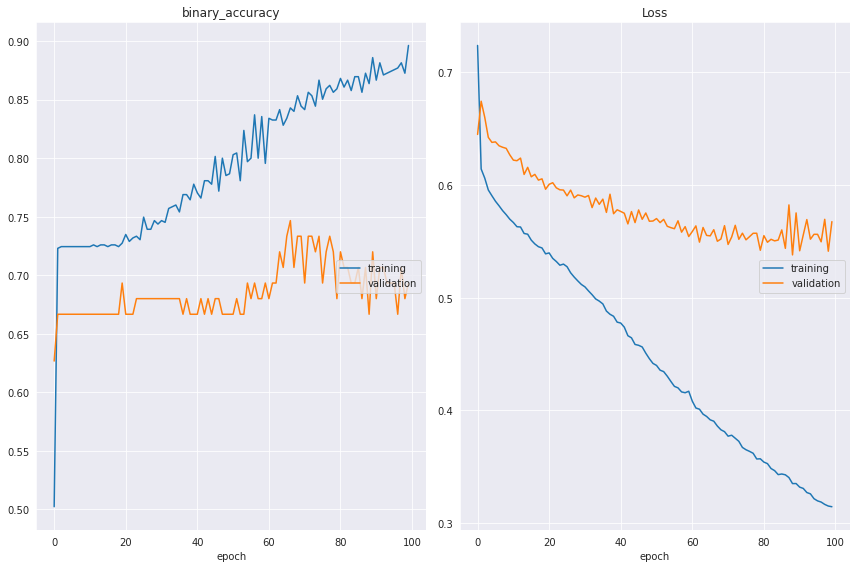

binary_accuracy
	training         	 (min:    0.502, max:    0.896, cur:    0.896)
	validation       	 (min:    0.627, max:    0.747, cur:    0.693)
Loss
	training         	 (min:    0.314, max:    0.724, cur:    0.314)
	validation       	 (min:    0.538, max:    0.674, cur:    0.568)


In [25]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [23]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data) in enumerate(zip(X_data_list, y_data_list)))  
del parallel

[Parallel(n_jobs=-5)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-5)]: Done  88 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-5)]: Done 248 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-5)]: Done 472 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-5)]: Done 760 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-5)]: Done 1112 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-5)]: Done 1528 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-5)]: Done 2008 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-5)]: Done 2552 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-5)]: Done 3160 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-5)]: Done 3832 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-5)]: Done 4568 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-5)]: Done 5368 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-5)]: Done 6232 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-5)]: Done 7160 tasks      | elapsed: 53.7min
[Parallel(n_jobs=-5)]: Done 8152 tasks      |

In [26]:
random_network['model'].get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 15),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'batch_input_shape': (None, 15),
    'dtype': 'float32',
    'units': 256,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initial

In [27]:
random_network['model'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [28]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [29]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [30]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_142,loss_epoch_143,loss_epoch_144,loss_epoch_145,loss_epoch_146,loss_epoch_147,loss_epoch_148,loss_epoch_149,loss_epoch_150,loss_epoch_151,loss_epoch_152,loss_epoch_153,loss_epoch_154,loss_epoch_155,loss_epoch_156,loss_epoch_157,loss_epoch_158,loss_epoch_159,loss_epoch_160,loss_epoch_161,loss_epoch_162,loss_epoch_163,loss_epoch_164,loss_epoch_165,loss_epoch_166,loss_epoch_167,loss_epoch_168,loss_epoch_169,loss_epoch_170,loss_epoch_171,loss_epoch_172,loss_epoch_173,loss_epoch_174,loss_epoch_175,loss_epoch_176,loss_epoch_177,loss_epoch_178,loss_epoch_179,loss_epoch_180,loss_epoch_181,loss_epoch_182,loss_epoch_183,loss_epoch_184,loss_epoch_185,loss_epoch_186,loss_epoch_187,loss_epoch_188,loss_epoch_189,loss_epoch_190,loss_epoch_191,loss_epoch_192,loss_epoch_193,loss_epoch_194,loss_epoch_195,loss_epoch_196,loss_epoch_197,loss_epoch_198,loss_epoch_199,loss_epoch_200,loss_epoch_201,loss_epoch_202,loss_epoch_203,loss_epoch_204,loss_epoch_205,loss_epoch_206,loss_epoch_207,loss_epoch_208,loss_epoch_209,loss_epoch_210,loss_epoch_211,loss_epoch_212,loss_epoch_213,loss_epoch_214,loss_epoch_215,loss_epoch_216,loss_epoch_217,loss_epoch_218,loss_epoch_219,loss_epoch_220,loss_epoch_221,loss_epoch_222,loss_epoch_223,loss_epoch_224,loss_epoch_225,loss_epoch_226,loss_epoch_227,loss_epoch_228,loss_epoch_229,loss_epoch_230,loss_epoch_231,loss_epoch_232,loss_epoch_233,loss_epoch_234,loss_epoch_235,loss_epoch_236,loss_epoch_237,loss_epoch_238,loss_epoch_239,loss_epoch_240,loss_epoch_241
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9975.000,9955.000,9946.000,9934.000,9917.000,9888.000,9858.000,9813.000,9776.000,9737.000,9684.000,9615.000,9549.000,9487.000,9423.000,9360.000,9297.000,9255.000,9199.000,9147.000,9099.000,9059.000,9015.000,8978.000,8934.000,8888.000,8848.000,8803.000,8769.000,8731.000,8680.000,8638.000,8608.000,8561.000,8523.000,8483.000,8447.000,8404.000,8356.000,8330.000,8288.000,8255.000,8217.000,8186.000,8138.000,8099.000,8054.000,8005.000,7954.000,7914.000,7870.000,7821.000,7767.000,7716.000,7646.000,7586.000,7529.000,7463.000,7400.000,7343.000,7266.000,7187.000,7112.000,7049.000,6981.000,6867.000,6790.000,6725.000,6639.000,6544.000,6459.000,6377.000,6279.000,6191.000,6092.000,5987.000,5887.000,5776.000,...,1582.000,1513.000,1450.000,1390.000,1322.000,1262.000,1212.000,1162.000,1111.000,1064.000,1012.000,962.000,916.000,861.000,817.000,778.000,729.000,688.000,653.000,616.000,573.000,5

In [31]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_142,val_loss_epoch_143,val_loss_epoch_144,val_loss_epoch_145,val_loss_epoch_146,val_loss_epoch_147,val_loss_epoch_148,val_loss_epoch_149,val_loss_epoch_150,val_loss_epoch_151,val_loss_epoch_152,val_loss_epoch_153,val_loss_epoch_154,val_loss_epoch_155,val_loss_epoch_156,val_loss_epoch_157,val_loss_epoch_158,val_loss_epoch_159,val_loss_epoch_160,val_loss_epoch_161,val_loss_epoch_162,val_loss_epoch_163,val_loss_epoch_164,val_loss_epoch_165,val_loss_epoch_166,val_loss_epoch_167,val_loss_epoch_168,val_loss_epoch_169,val_loss_epoch_170,val_loss_epoch_171,val_loss_epoch_172,val_loss_epoch_173,val_loss_epoch_174,val_loss_epoch_175,val_loss_epoch_176,val_loss_epoch_177,val_loss_epoch_178,val_loss_epoch_179,val_loss_epoch_180,val_loss_epoch_181,val_loss_epoch_182,val_loss_epoch_183,val_loss_epoch_184,val_loss_epoch_185,val_loss_epoch_186,val_loss_epoch_187,val_loss_epoch_188,val_loss_epoch_189,val_loss_epoch_190,val_loss_epoch_191,val_loss_epoch_192,val_loss_epoch_193,val_loss_epoch_194,val_loss_epoch_195,val_loss_epoch_196,val_loss_epoch_197,val_loss_epoch_198,val_loss_epoch_199,val_loss_epoch_200,val_loss_epoch_201,val_loss_epoch_202,val_loss_epoch_203,val_loss_epoch_204,val_loss_epoch_205,val_loss_epoch_206,val_loss_epoch_207,val_loss_epoch_208,val_loss_epoch_209,val_loss_epoch_210,val_loss_epoch_211,val_loss_epoch_212,val_loss_epoch_213,val_loss_epoch_214,val_loss_epoch_215,val_loss_epoch_216,val_loss_epoch_217,val_loss_epoch_218,val_loss_epoch_219,val_loss_epoch_220,val_loss_epoch_221,val_loss_epoch_222,val_loss_epoch_223,val_loss_epoch_224,val_loss_epoch_225,val_loss_epoch_226,val_loss_epoch_227,val_loss_epoch_228,val_loss_epoch_229,val_loss_epoch_230,val_loss_epoch_231,val_loss_epoch_232,val_loss_epoch_233,val_loss_epoch_234,val_loss_epoch_235,val_loss_epoch_236,val_loss_epoch_237,val_loss_epoch_238,val_loss_epoch_239,val_loss_epoch_240,val_loss_epoch_241
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9975.000,9955.000,9946.000,9934.000,9917.000,9888.000,9858.000,9813.000,9776.000,9737.000,

In [32]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_142,binary_accuracy_epoch_143,binary_accuracy_epoch_144,binary_accuracy_epoch_145,binary_accuracy_epoch_146,binary_accuracy_epoch_147,binary_accuracy_epoch_148,binary_accuracy_epoch_149,binary_accuracy_epoch_150,binary_accuracy_epoch_151,binary_accuracy_epoch_152,binary_accuracy_epoch_153,binary_accuracy_epoch_154,binary_accuracy_epoch_155,binary_accuracy_epoch_156,binary_accuracy_epoch_157,binary_accuracy_epoch_158,binary_accuracy_epoch_159,binary_accuracy_epoch_160,binary_accuracy_epoch_161,binary_accuracy_epoch_162,binary_accuracy_epoch_163,binary_accuracy_epoch_164,binary_accuracy_epoch_165,binary_accuracy_epoch_166,binary_accuracy_epoch_167,binary_accuracy_epoch_168,binary_accuracy_epoch_169,binary_accuracy_epoch_170,binary_accuracy_epoch_171,binary_accuracy_epoch_172,binary_accuracy_epoch_173,binary_accuracy_epoch_174,binary_accuracy_epoch_175,binary_accuracy_epoch_176,binary_accuracy_epoch_177,binary_accuracy_epoch_178,binary_accuracy_epoch_179,binary_accuracy_epoch_180,binary_accuracy_epoch_181,binary_accuracy_epoch_182,binary_accuracy_epoch_183,binary_accuracy_epoch_184,binary_accuracy_epoch_185,binary_accuracy_epoch_186,binary_accuracy_epoch_187,binary_accuracy_epoch_188,binary_accuracy_epoch_189,binary_accuracy_epoch_190,binary_accuracy_epoch_191,binary_accuracy_epoch_192,binary_accuracy_epoch_193,binary_accuracy_epoch_194,binary_accuracy_epoch_195,binary_accuracy_epoch_196,binary_accuracy_epoch_197,binary_accuracy_epoch_198,binary_accuracy_epoch_199,binary_accuracy

In [33]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_142,val_binary_accuracy_epoch_143,val_binary_accuracy_epoch_144,val_binary_accuracy_epoch_145,val_binary_accuracy_epoch_146,val_binary_accuracy_epoch_147,val_binary_accuracy_epoch_148,val_binary_accuracy_epoch_149,val_binary_accuracy_epoch_150,val_binary_accuracy_epoch_151,val_binary_accuracy_epoch_152,val_binary_accuracy_epoch_153,val_binary_accuracy_epoch_154,val_binary_accuracy_epoch_155,val_binary_accuracy_epoch_156,val_binary_accuracy_epoch_157,val_binary_accuracy_epoch_158,val_binary_accuracy_epoch_159,val_binary_accuracy_epoch_160,val_binary_accuracy_epoch_161,val_binary_accuracy_epoch_162,val_binary_accuracy_epoch_163,val_binary_accuracy_epoch_164,val_binary_accuracy_epoch_165,val_binary_accuracy_epoch_166,val_binary_accuracy_epoch_167,val_binary_accuracy_epoch_168,val_binary_accuracy_epoch_169,val_binary_accuracy_epoch_170,val_binary_accuracy_epoch_171,val_binary_accuracy_epoch_172,val_binary_accuracy_epoch_173,val_binary_accuracy_epoch_174,val_binary_accuracy_epoch_175,val_binary_accuracy_epoch_176,val_binary_accuracy_epoch_177,val_binary_accuracy_epoch_178,val_binary_accura

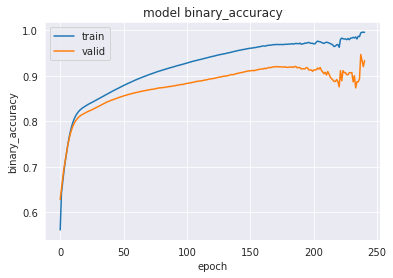

In [34]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


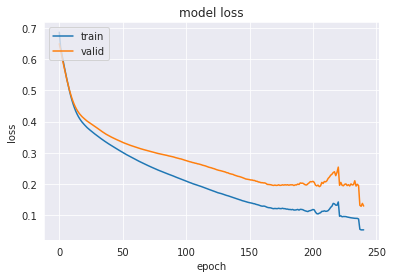

In [35]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()
